<a href="https://colab.research.google.com/github/abishekP101/Pytorch/blob/main/Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abishek11prasad
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification


100%|██████████| 2.12G/2.12G [00:13<00:00, 173MB/s]


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
from torch.optim import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize
import librosa

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
data = pd.read_csv("/content/quran-recitations-for-audio-classification/files_paths.csv")

In [ ]:
data.head()

,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [ ]:
data['Class'].unique()

array(['Mohammed_Aluhaidan', 'Yasser_Aldossary', 'Maher_Almuaiqly',
       'Nasser_Alqutami', 'AbdulBari_Althubaity', 'Bander_Balilah',
       'Ali_Alhothaify', 'Saud_Alshuraim', 'Mohammed_Ayoub',
       'AbdulRahman_Alsudais', 'Saad_Alghamdi', 'Abdullah_Albuaijan'],
      dtype=object)

In [ ]:
data['Class'].value_counts()

,count
Class,
Saud_Alshuraim,696
Saad_Alghamdi,688
AbdulRahman_Alsudais,648
Yasser_Aldossary,576
Ali_Alhothaify,576
Bander_Balilah,576
Maher_Almuaiqly,576
Abdullah_Albuaijan,504
Mohammed_Ayoub,480


In [ ]:
data['FilePath'] = '/content/quran-recitations-for-audio-classification/Dataset'+data['FilePath'].str[1:]

In [ ]:
data.head()

,FilePath,Class
0,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
1,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
2,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
3,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan
4,/content/quran-recitations-for-audio-classific...,Mohammed_Aluhaidan


In [ ]:
data['FilePath'][0]

'/content/quran-recitations-for-audio-classification/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_171.wav'

In [ ]:
data.shape

(6687, 2)

In [ ]:
label = LabelEncoder()
data['Class'] = label.fit_transform(data['Class'])

In [ ]:
train = data.sample(frac=0.7 , random_state=42)
test = data.drop(train.index)


val = test.sample(frac=0.5 , random_state=42)
test = test.drop(val.index)

In [ ]:
class CustomAudioDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.labels = list(data['Class'])  # Keep labels as raw values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 0]
        label = torch.tensor(self.labels[index], dtype=torch.long)
        audio = torch.tensor(self.get_spectogram(img_path), dtype=torch.float32).unsqueeze(0)
        return audio, label

    def get_spectogram(self, path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256
        signal, sr = librosa.load(path, sr=sr, duration=duration)
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=img_height, n_fft=2048, hop_length=512)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_resized = resize(spec_db, (img_height, img_width), anti_aliasing=True)
        # Optionally normalize:
        spec_resized = (spec_resized - spec_resized.mean()) / (spec_resized.std() + 1e-6)
        return spec_resized


In [ ]:
train_dataset = CustomAudioDataset(train)
test_dataset = CustomAudioDataset(test)
val_dataset = CustomAudioDataset(val)

In [ ]:
learning_rate = 1e-4
batch_size = 16
epochs = 25

In [ ]:
train_loader = DataLoader(train_dataset , batch_size=batch_size , shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=batch_size , shuffle=True)
test_loader = DataLoader(test_dataset , batch_size=batch_size , shuffle=True)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net , self).__init__()
    self.conv1 = nn.Conv2d(1 , 16 , kernel_size=3 , padding=1)
    self.conv2 = nn.Conv2d(16 , 32 , kernel_size=3 , padding=1)
    self.conv3 = nn.Conv2d(32 , 64 , kernel_size=3 , padding=1)
    self.pool = nn.MaxPool2d(2 , 2)
    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(64 * 16 * 32 , 4096)
    self.linear2 = nn.Linear(4096 , 1024)
    self.linear3 = nn.Linear(1024 , 512)
    self.output = nn.Linear(512 , len(data['Class'].unique()))
    self.dropout = nn.Dropout(0.5)

  def forward(self , x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.pool(x)
    x = self.relu(x)

    x = x.view(x.size(0) , -1)
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.dropout(x)

    x = self.linear2(x)
    x = self.dropout(x)

    x = self.linear3(x)
    x = self.dropout(x)

    x = self.output(x)

    return x

In [ ]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
from torchsummary import summary

In [ ]:
summary(model ,(1 , 128 , 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters() , lr=learning_rate)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_accuracy_train_plot = []
total_accuracy_validation_plot = []

for epoch in range(epochs):
    model.train()
    total_acc_train = 0
    total_loss_train = 0

    for input, label in train_loader:
        input = input.to(device)
        label = label.to(device)

        output = model(input)
        loss = criterion(output, label)
        total_loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(output, dim=1)
        total_acc_train += (predictions == label).sum().item()

    model.eval()
    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
        for input, label in val_loader:
            input = input.to(device)
            label = label.to(device)

            output = model(input)
            loss = criterion(output, label)
            total_loss_val += loss.item()

            predictions = torch.argmax(output, dim=1)
            total_acc_val += (predictions == label).sum().item()

    avg_loss_train = round(total_loss_train / len(train_loader), 4)
    avg_loss_val = round(total_loss_val / len(val_loader), 4)
    avg_acc_train = round((total_acc_train / len(train_dataset)) * 100, 4)
    avg_acc_val = round((total_acc_val / len(val_dataset)) * 100, 4)


    total_loss_train_plot.append(avg_loss_train)
    total_loss_validation_plot.append(avg_loss_val)
    total_accuracy_train_plot.append(avg_acc_train)
    total_accuracy_validation_plot.append(avg_acc_val)

    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"  Train Loss: {avg_loss_train} | Train Accuracy: {avg_acc_train}%")
    print(f"  Val   Loss: {avg_loss_val} | Val   Accuracy: {avg_acc_val}%")
    print("=" * 40)


Epoch: 1/25
  Train Loss: 1.0578 | Train Accuracy: 65.4988%
  Val   Loss: 0.2224 | Val   Accuracy: 94.2173%
Epoch: 2/25
  Train Loss: 0.2256 | Train Accuracy: 92.8648%
  Val   Loss: 0.0828 | Val   Accuracy: 97.2084%
Epoch: 3/25
  Train Loss: 0.1166 | Train Accuracy: 96.1547%
  Val   Loss: 0.2417 | Val   Accuracy: 94.317%
Epoch: 4/25
  Train Loss: 0.079 | Train Accuracy: 97.5646%
  Val   Loss: 0.0583 | Val   Accuracy: 98.3051%
Epoch: 5/25
  Train Loss: 0.0616 | Train Accuracy: 98.1201%
  Val   Loss: 0.0397 | Val   Accuracy: 98.9033%
Epoch: 6/25
  Train Loss: 0.0497 | Train Accuracy: 98.5473%
  Val   Loss: 0.0449 | Val   Accuracy: 99.003%
Epoch: 7/25
  Train Loss: 0.0366 | Train Accuracy: 99.0173%
  Val   Loss: 0.1403 | Val   Accuracy: 96.1117%
Epoch: 8/25
  Train Loss: 0.0494 | Train Accuracy: 98.526%
  Val   Loss: 0.1097 | Val   Accuracy: 97.1087%
Epoch: 9/25
  Train Loss: 0.0636 | Train Accuracy: 98.2055%
  Val   Loss: 0.2358 | Val   Accuracy: 93.8185%
Epoch: 10/25
  Train Loss: 0.037

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs , labels  in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    prediction = model(inputs)
    acc = (torch.argmax(prediction , axis=1)==labels).sum().item()
    total_acc_test += acc

  avg_acc_test = round((total_acc_test / len(test_dataset)) * 100, 4)
  print(f"Test Accuracy: {avg_acc_test}%")

Test Accuracy: 97.5075%


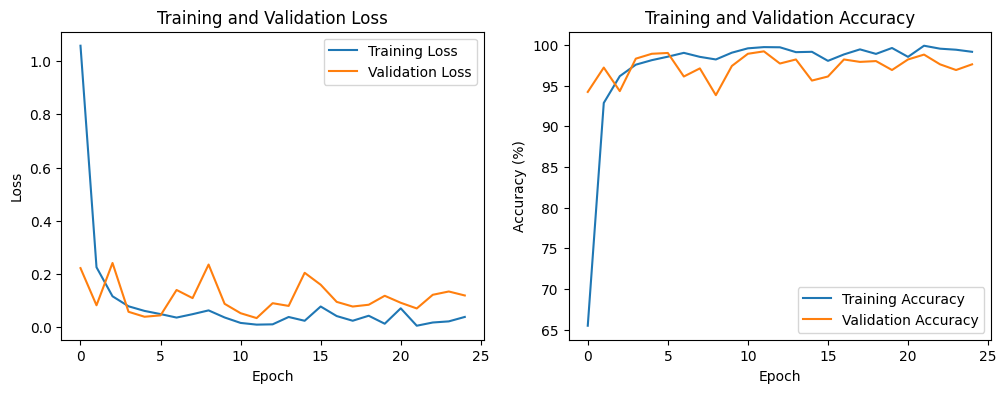

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(total_loss_train_plot, label='Training Loss')
plt.plot(total_loss_validation_plot, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(total_accuracy_train_plot, label='Training Accuracy')
plt.plot(total_accuracy_validation_plot, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()